# Energy Time Series Forecasting

# README - Energy Time Series Forecasting Notebook

Ce notebook présente une approche complète pour la prévision de la consommation d'énergie du business groupe à Ålesund à partir de données historiques. Il inclut les étapes suivantes :

1. **Chargement et préparation des données** : Importation des bibliothèques, chargement des données, conversion des dates, création de nouvelles variables et nettoyage des colonnes inutiles.
2. **Feature engineering** : Extraction des composantes temporelles (heure, mois, jour de la semaine, jour de l'année) et encodage cyclique pour mieux représenter la périodicité.
3. **Prétraitement** : Analyse exploratoire (histogrammes, boxplots), normalisation des variables clés avec MinMaxScaler, et organisation des colonnes pour l'entraînement.
4. **Modélisation LSTM** : Construction et entraînement d'un modèle LSTM pour la prévision multi-horizon de la consommation d'énergie, avec évaluation des performances (MAE, RMSE, MAPE) pour différents horizons de prédiction.
5. **Sauvegarde des résultats** : Les modèles, historiques d'entraînement et résultats de performance sont sauvegardés pour chaque horizon testé.

**Objectif principal** : Étudier comment la performance du modèle LSTM évolue en fonction de l'horizon de prédiction.

**Fichiers générés** :
- `results_horizon.csv` : Résultats des performances pour chaque horizon.
- `models/model_h{horizon}.keras` : Modèles entraînés pour chaque horizon.
- `models/history_h{horizon}.json` : Historique d'entraînement pour chaque horizon.

**Prérequis** :
- Python 3.x
- Bibliothèques : pandas, numpy, matplotlib, seaborn, scikit-learn, torch, tensorflow, keras

**Utilisation** :
- Adapter le chemin du fichier de données (`business_group_data.csv`) si besoin.
- Exécuter les cellules dans l'ordre pour reproduire l'analyse et l'entraînement.

---

## Introduction

Prédiction de la consommation d’énergie du business groupe dans Alesund à partir des données historiques.

## Import des bibliothèques

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import seaborn as sns

## Chargement des données 

In [ ]:
df_business_consumption=pd.read_csv('business_group_data.csv')  # Load your dataset

In [ ]:
df_business_consumption['Date'] = pd.to_datetime(
 df_business_consumption['Date'])    # Convert 'Date' column to datetime

In [ ]:
# Création de la nouvelle colonne
df_business_consumption["Consommation"] = df_business_consumption["VOLUME_KWH"] / df_business_consumption["METERINGPOINT_COUNT"]  # Calcul de la consommation moyenne par point de mesure 

# Suppression des deux colonnes d'origine
df_business_consumption.drop(columns=["VOLUME_KWH", "METERINGPOINT_COUNT"], inplace=True)  # Drop the original columns


## Feature engineering

In [ ]:

# Extraire les composants de date
df_business_consumption['hour'] = df_business_consumption['Date'].dt.hour   #extract hour from Date between 0 and 23
df_business_consumption['month'] = df_business_consumption['Date'].dt.month   # extract month from Date between 1 and 12
df_business_consumption['weekday'] = df_business_consumption['Date'].dt.weekday  # extract weekday 0 = lundi, 6 = dimanche
df_business_consumption['dayofyear'] = df_business_consumption['Date'].dt.dayofyear # extract day of year from Date between 1 and 365

# Vérification
df_business_consumption.head()


,Date,wind_speed,t2m_C,surface_pressure,Consommation,hour,month,weekday,dayofyear
0,2021-01-01 00:00:00,2.798005,1.68923,98874.560,8.082154,0,1,4,1
1,2021-01-01 01:00:00,2.630726,1.32168,98905.060,8.021209,1,1,4,1
2,2021-01-01 02:00:00,2.387332,1.01553,98930.625,8.132821,2,1,4,1
3,2021-01-01 03:00:00,1.984651,0.77847,98928.000,8.151846,3,1,4,1
4,2021-01-01 04:00:00,1.515596,0.66543,98949.560,8.389451,4,1,4,1


In [ ]:
df_business_consumption.drop(columns=["wind_speed", "surface_pressure"], inplace=True) # Drop the columns that are not needed for the model based on the previous analysis

##  Prétraitement des données

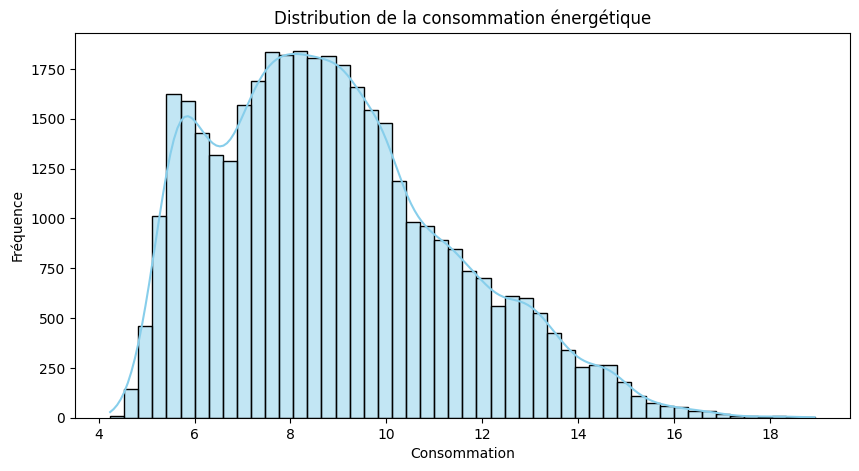

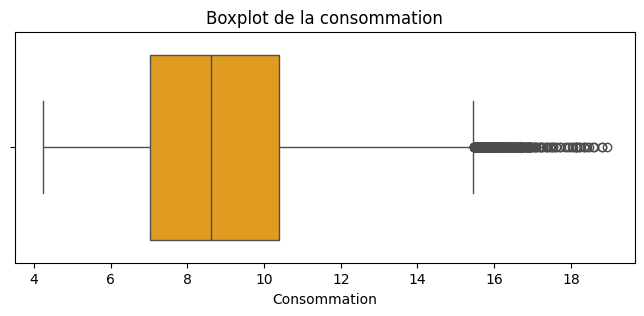

In [7]:

# Histogramme
plt.figure(figsize=(10, 5))
sns.histplot(df_business_consumption["Consommation"], bins=50, kde=True, color="skyblue")
plt.title("Distribution de la consommation énergétique")
plt.xlabel("Consommation")
plt.ylabel("Fréquence")
plt.show()

# Boxplot (pour voir les outliers)
plt.figure(figsize=(8, 3))
sns.boxplot(x=df_business_consumption["Consommation"], color="orange")
plt.title("Boxplot de la consommation")
plt.show()


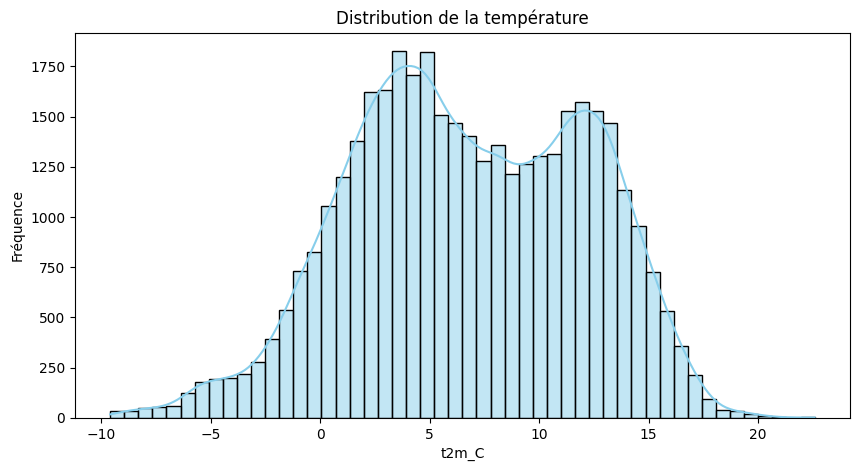

In [8]:
# Histogramme
plt.figure(figsize=(10, 5))
sns.histplot(df_business_consumption["t2m_C"], bins=50, kde=True, color="skyblue")
plt.title("Distribution de la température")
plt.xlabel("t2m_C")
plt.ylabel("Fréquence")
plt.show()

MinMaxScaler  il est plus adapté aux données asymétriques .

In [ ]:
from sklearn.preprocessing import MinMaxScaler  # MinMaxScaler is more suitable for asymmetric and bounded data.
df_normalise=df_business_consumption.copy()     # Create a copy of the DataFrame to avoid modifying the original data
# Liste des colonnes à normaliser
colonnes_a_normaliser = ["Consommation" , "t2m_C"]  # List of columns to normalize
scalers_minmax = {}     # Dictionary to store the scalers for each column
for col in colonnes_a_normaliser:     # Iterate over each column to normalize
    scaler = MinMaxScaler()    # Create a MinMaxScaler instance
    df_normalise[col] = scaler.fit_transform(df_normalise[[col]])   # Fit and transform the column using the scaler
    scalers_minmax[col] = scaler    # Store the scaler in the dictionary for later use


In [ ]:
# Encodage cyclique
df_normalise["hour_sin"] = np.sin(2 * np.pi * df_normalise["hour"] / 24)   # Encode hour cyclically between 0 and 23
df_normalise["hour_cos"] = np.cos(2 * np.pi * df_normalise["hour"] / 24)   # Encode hour cyclically between 0 and 23

df_normalise["month_sin"] = np.sin(2 * np.pi * df_normalise["month"] / 12)   # Encode month cyclically between 1 and 12
df_normalise["month_cos"] = np.cos(2 * np.pi * df_normalise["month"] / 12)  # Encode month cyclically between 1 and 12

df_normalise["weekday_sin"] = np.sin(2 * np.pi * df_normalise["weekday"] / 7)     # Encode weekday cyclically between 0 and 6
df_normalise["weekday_cos"] = np.cos(2 * np.pi * df_normalise["weekday"] / 7)    # Encode weekday cyclically between 0 and 6

df_normalise["dayofyear_sin"] = np.sin(2 * np.pi * df_normalise["dayofyear"] / 365)    # Encode day of year cyclically between 1 and 365
df_normalise["dayofyear_cos"] = np.cos(2 * np.pi * df_normalise["dayofyear"] / 365)    # Encode day of year cyclically between 1 and 365

In [11]:
df_normalise

,Date,t2m_C,Consommation,hour,month,weekday,dayofyear,hour_sin,hour_cos,month_sin,month_cos,weekday_sin,weekday_cos,dayofyear_sin,dayofyear_cos
0,2021-01-01 00:00:00,0.350590,0.261538,0,1,4,1,0.000000e+00,1.000000,0.5,0.866025,-0.433884,-0.900969,0.017213,0.999852
1,2021-01-01 01:00:00,0.339167,0.257389,1,1,4,1,2.588190e-01,0.965926,0.5,0.866025,-0.433884,-0.900969,0.017213,0.999852
2,2021-01-01 02:00:00,0.329652,0.264986,2,1,4,1,5.000000e-01,0.866025,0.5,0.866025,-0.433884,-0.900969,0.017213,0.999852
3,2021-01-01 03:00:00,0.322284,0.266281,3,1,4,1,7.071068e-01,0.707107,0.5,0.866025,-0.433884,-0.900969,0.017213,0.999852
4,2021-01-01 04:00:00,0.318771,0.282455,4,1,4,1,8.660254e-01,0.500000,0.5,0.866025,-0.433884,-0.900969,0.017213,0.999852
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38457,2025-05-22 09:00:00,0.508829,0.560058,9,5,3,142,7.071068e-01,-0.707107,0.5,-0.866025,0.433884,-0.900969,0.642055,-0.766659
38458,2025-05-22 10:00:00,0.506474,0.550630,10,5,3,142,5.000000e-01,-0.866025,0.5,-0.866025,0.433884,-0.900969,0.642055,-0.766659
38459,2025-05-22 11:00:00,0.517676,0.543712,11,5,3,142,2.588190e-01,-0.965926,0.5,-0.866025,0.433884,-0.900969,0.642055,-0.766659
38460,2025-05-22 12:00:00,0.524023,0.522251,12,5,3,142,1.224647e-16,-1.000000,0.5,-0.866025,0.433884,-0.900969,0.642055,-0.766659


In [ ]:
df_normalise.index=df_normalise['Date']   # Set the index to the 'Date' column for time series analysis

df_normalise.drop(columns=["Date","hour", "month", "weekday", "dayofyear"], inplace=True) # Drop the original date and time columns as they are no longer needed

df_normalise.head()

,t2m_C,Consommation,hour_sin,hour_cos,month_sin,month_cos,weekday_sin,weekday_cos,dayofyear_sin,dayofyear_cos
Date,,,,,,,,,,
2021-01-01 00:00:00,0.350590,0.261538,0.000000,1.000000,0.5,0.866025,-0.433884,-0.900969,0.017213,0.999852
2021-01-01 01:00:00,0.339167,0.257389,0.258819,0.965926,0.5,0.866025,-0.433884,-0.900969,0.017213,0.999852
2021-01-01 02:00:00,0.329652,0.264986,0.500000,0.866025,0.5,0.866025,-0.433884,-0.900969,0.017213,0.999852
2021-01-01 03:00:00,0.322284,0.266281,0.707107,0.707107,0.5,0.866025,-0.433884,-0.900969,0.017213,0.999852
2021-01-01 04:00:00,0.318771,0.282455,0.866025,0.500000,0.5,0.866025,-0.433884,-0.900969,0.017213,0.999852


In [ ]:
col = 'Consommation'
# Réorganiser les colonnes
df_normalise = df_normalise[[col] + [c for c in df_normalise.columns if c != col]]    # Reorder columns to have 'Consommation' first

In [14]:
df_normalise.head()

,Consommation,t2m_C,hour_sin,hour_cos,month_sin,month_cos,weekday_sin,weekday_cos,dayofyear_sin,dayofyear_cos
Date,,,,,,,,,,
2021-01-01 00:00:00,0.261538,0.350590,0.000000,1.000000,0.5,0.866025,-0.433884,-0.900969,0.017213,0.999852
2021-01-01 01:00:00,0.257389,0.339167,0.258819,0.965926,0.5,0.866025,-0.433884,-0.900969,0.017213,0.999852
2021-01-01 02:00:00,0.264986,0.329652,0.500000,0.866025,0.5,0.866025,-0.433884,-0.900969,0.017213,0.999852
2021-01-01 03:00:00,0.266281,0.322284,0.707107,0.707107,0.5,0.866025,-0.433884,-0.900969,0.017213,0.999852
2021-01-01 04:00:00,0.282455,0.318771,0.866025,0.500000,0.5,0.866025,-0.433884,-0.900969,0.017213,0.999852


## @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

## Variation d'horizon de temps 

 répondre à une question :

 Comment la performance de mon modèle LSTM se dégrade-t-elle lorsque j’essaie de prédire de plus en plus loin dans le futur (augmentation de l’horizon de prédiction) ?

In [ ]:
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0' # Désactiver les optimisations OneDNN de TensorFlow
import json      # Importer json pour sauvegarder l'historique
import tensorflow as tf   # Importer TensorFlow
from tensorflow.keras.models import Sequential         # Importer les modules nécessaires
from tensorflow.keras.layers import LSTM, Dense        # Importer les couches LSTM et Dense
from tensorflow.keras.optimizers import Adam          # Importer l'optimiseur Adam qui est utilisé pour l'entraînement pour optimiser la fonction de perte 
from tensorflow.keras import backend as K            # Importer les fonctions backend de Keras pour la gestion de la mémoire
from tensorflow.keras.metrics import MeanAbsolutePercentageError        # Importer la métrique MAPE pour évaluer la performance du modèle
from sklearn.metrics import mean_squared_error, mean_absolute_error        # Importer les métriques de performance pour évaluer le modèle
import gc   # Importer le module gc pour la gestion de la mémoire

# Paramètres fixes
sequence_length = 48      # Longueur de la séquence d'entrée
learning_rate = 0.0001     # Taux d'apprentissage pour l'optimiseur Adam 
batch_size = 30           # Taille du batch pour l'entraînement
epochs = 40       # Nombre d'époques pour l'entraînement
target_col = "Consommation"     # Colonne cible pour la prédiction

# Fonction pour créer les séquences
def create_sequences(data, target_col, sequence_length, forecast_horizon):          # Fonction pour créer les séquences
    X, y = [], []
    for i in range(len(data) - sequence_length - forecast_horizon):    # Boucle pour créer les séquences
        X.append(data.iloc[i:i+sequence_length].values)         # Séquence d'entrée
        y.append(data.iloc[i+sequence_length:i+sequence_length+forecast_horizon][target_col].values)     # Séquence cible
    return np.array(X), np.array(y)   

# Générer les horizons avec pas variable
forecast_horizons = list(range(1, 110)) \
                 + list(range(110, 301, 10)) \
                 + list(range(300, 2001, 100))          # Liste des horizons de prévision à tester

# Chargement des résultats sauvegardés
results_file = 'results_horizon.csv'    # Fichier pour stocker les résultats des prévisions
print("Chargement du fichier :", results_file)
if os.path.exists(results_file):          # Vérifier si le fichier existe
    results_df = pd.read_csv(results_file)    # Charger les résultats précédents
    processed_horizons = set(results_df['horizon'].values)    # Extraire les horizons déjà traités
    print("Nombre d'horizons déjà traités :", len(processed_horizons))     # Si le fichier existe, on charge les résultats précédents
else:       # Si le fichier n'existe pas, on initialise un DataFrame vide
    processed_horizons = set()      # Initialiser un ensemble vide pour les horizons traités
    results_df = pd.DataFrame(columns=["horizon", "MAE", "RMSE", "MAPE"])      # Initialiser un DataFrame vide pour stocker les résultats

# Boucle principale
for horizon in forecast_horizons:      # Pour chaque horizon de prévision
    if horizon in processed_horizons:     # Si l'horizon a déjà été traité, on passe au suivant
        print(f"Horizon {horizon} déjà traité, passage au suivant.")       # Si l'horizon a déjà été traité, on passe au suivant
        continue   # Si l'horizon a déjà été traité, on passe au suivant
    
    print(f"Training for forecast_horizon = {horizon}...")       # Afficher l'horizon de prévision en cours de traitement

    # Création des données
    X, y = create_sequences(df_normalise, target_col, sequence_length, horizon)     # Créer les séquences d'entrée et de sortie pour l'horizon de prévision actuel
    split_idx = int(0.8 * len(X))         # Indice de séparation pour l'entraînement et le test
    X_train, X_test = X[:split_idx], X[split_idx:]   # Séparer les données en ensembles d'entraînement et de test
    y_train, y_test = y[:split_idx], y[split_idx:]    # Séparer les cibles en ensembles d'entraînement et de test

    # Modèle LSTM 
    model = Sequential([
        LSTM(64, return_sequences=True, dropout=0.1, recurrent_dropout=0.1, input_shape=(sequence_length, X.shape[2])), # Première couche LSTM
        LSTM(32, dropout=0.1, recurrent_dropout=0.1, return_sequences=False),       # Deuxième couche LSTM
        Dense(horizon, activation='linear')   # Couche de sortie pour prédire l'horizon de prévision
    ])

    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse', metrics=[MeanAbsolutePercentageError()])    # Compiler le modèle avec l'optimiseur Adam et la métrique MAPE

    # Entraînement
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_test, y_test),
        verbose=0
    )

    # Prédiction
    y_pred = model.predict(X_test)   # Faire des prédictions sur l'ensemble de test

    # Dénormalisation
    scaler = scalers_minmax["Consommation"] # Récupérer le scaler pour la dénormalisation que nous avons utilisé MinMaxScaler pour normaliser les données
    y_test_denorm = scaler.inverse_transform(y_test.reshape(-1, 1))       # Dénormaliser les valeurs réelles nous avons utilisé reshape pour s'assurer que y_test a la bonne forme pour la dénormalisation
    y_pred_denorm = scaler.inverse_transform(y_pred.reshape(-1, 1))     # Dénormaliser les valeurs prédites

    # Calcul des métriques
    mae = mean_absolute_error(y_test_denorm, y_pred_denorm)      #calculer l'erreur absolue moyenne (MAE) 
    rmse = np.sqrt(mean_squared_error(y_test_denorm, y_pred_denorm))   #calculer la racine carrée de l'erreur quadratique moyenne (RMSE)
    mape = np.mean(np.abs((y_test_denorm - y_pred_denorm) / (y_test_denorm + 1e-8))) * 100    # calculer l'erreur absolue moyenne en pourcentage (MAPE) en évitant la division par zéro on ajoute une petite constante (1e-8)
    # Sauvegarde du modèle
    model_path = f"models/model_h{horizon}.keras"     # Chemin pour sauvegarder le modèle
    model.save(model_path)

    # Sauvegarde de l’historique
    history_path = f"models/history_h{horizon}.json"    # Chemin pour sauvegarder l'historique de l'entraînement
    with open(history_path, 'w') as f:
       json.dump(history.history, f)
       
    # Sauvegarde du résultat
    new_row = pd.DataFrame([{
    "horizon": horizon,
    "MAE": mae,
    "RMSE": rmse,
    "MAPE": mape
    }])

    results_df = pd.concat([results_df, new_row], ignore_index=True)   # Ajouter la nouvelle ligne de résultats au DataFrame existant


    results_df.to_csv(results_file, index=False)  # Sauvegarder les résultats dans le fichier CSV

    # Libération mémoire
    K.clear_session()
    del model, X, y, X_train, X_test, y_train, y_test, y_pred, y_test_denorm, y_pred_denorm
    gc.collect()


Chargement du fichier : results_horizon.csv
Nombre d'horizons déjà traités : 140
Horizon 1 déjà traité, passage au suivant.
Horizon 2 déjà traité, passage au suivant.
Horizon 3 déjà traité, passage au suivant.
Horizon 4 déjà traité, passage au suivant.
Horizon 5 déjà traité, passage au suivant.
Horizon 6 déjà traité, passage au suivant.
Horizon 7 déjà traité, passage au suivant.
Horizon 8 déjà traité, passage au suivant.
Horizon 9 déjà traité, passage au suivant.
Horizon 10 déjà traité, passage au suivant.
Horizon 11 déjà traité, passage au suivant.
Horizon 12 déjà traité, passage au suivant.
Horizon 13 déjà traité, passage au suivant.
Horizon 14 déjà traité, passage au suivant.
Horizon 15 déjà traité, passage au suivant.
Horizon 16 déjà traité, passage au suivant.
Horizon 17 déjà traité, passage au suivant.
Horizon 18 déjà traité, passage au suivant.
Horizon 19 déjà traité, passage au suivant.
Horizon 20 déjà traité, passage au suivant.
Horizon 21 déjà traité, passage au suivant.
Hori

c:\Users\omghyly\Downloads\Nouveau dossier\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


231/231 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step

Training for forecast_horizon = 1600...


c:\Users\omghyly\Downloads\Nouveau dossier\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


231/231 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step
Training for forecast_horizon = 1700...


c:\Users\omghyly\Downloads\Nouveau dossier\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


230/230 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step
Training for forecast_horizon = 1800...


c:\Users\omghyly\Downloads\Nouveau dossier\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


229/229 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step
Training for forecast_horizon = 1900...


c:\Users\omghyly\Downloads\Nouveau dossier\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


229/229 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step
Training for forecast_horizon = 2000...


c:\Users\omghyly\Downloads\Nouveau dossier\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


228/228 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step
